https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [23]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [12]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [13]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

16:45:38 - cmdstanpy - INFO - Chain [1] start processing


16:45:38 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [14]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-15,13575.205915,10899.935137,16027.564724,13976,2021-01-14
1,2021-01-16,13528.583886,11066.499155,16250.956829,13501,2021-01-14
2,2021-01-17,17707.497505,15167.784515,20323.310697,26969,2021-01-14
3,2021-01-18,12933.158250,10522.919097,15512.166644,12295,2021-01-14
4,2021-01-19,12592.543288,9847.671638,15168.486532,11463,2021-01-14


Plot the result

In [15]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,9.646013e+06,3105.803113,2483.110555,1.155424,0.525985,0.776565,0.587778


RMSE of the result

In [16]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

1.155423804860344

In [17]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] start

1.131356320622832

In [18]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:45:44 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:4

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [19]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])
auto_model_cv = cross_validation(auto_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p

16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:54 - cmdstanpy - INFO - Chain [1] done p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,8.355619e+06,2890.608744,2116.768782,0.68474,0.514226,0.614395,0.796667


In [20]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-07-04,671.792831,-2334.295407,3522.592048,671.792831,671.792831,-0.149771,-0.149771,-0.149771,-0.083999,-0.083999,-0.083999,-0.065772,-0.065772,-0.065772,0.0,0.0,0.0,571.177481
1,2023-07-05,666.014925,-2284.326341,3229.296422,666.014925,666.014925,-0.115690,-0.115690,-0.115690,-0.051366,-0.051366,-0.051366,-0.064323,-0.064323,-0.064323,0.0,0.0,0.0,588.963818
2,2023-07-06,660.237020,-2130.974581,3488.747673,660.237020,660.237020,-0.072600,-0.072600,-0.072600,-0.010121,-0.010121,-0.010121,-0.062479,-0.062479,-0.062479,0.0,0.0,0.0,612.303629
3,2023-07-07,654.459114,-2291.355247,3331.191833,654.459114,654.459114,-0.063780,-0.063780,-0.063780,-0.003522,-0.003522,-0.003522,-0.060259,-0.060259,-0.060259,0.0,0.0,0.0,612.717483
4,2023-07-08,648.681209,-2213.177896,3633.756845,648.681209,648.681209,-0.073187,-0.073187,-0.073187,-0.015499,-0.015499,-0.015499,-0.057689,-0.057689,-0.057689,0.0,0.0,0.0,601.205937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2023-11-18,-119.780229,-3118.963788,2801.395731,-871.954401,556.937855,-0.011305,-0.011305,-0.011305,-0.015499,-0.015499,-0.015499,0.004194,0.004194,0.004194,0.0,0.0,0.0,-118.426118
138,2023-11-19,-125.558134,-3302.578532,2637.053963,-885.093020,560.615005,0.231768,0.231768,0.231768,0.225243,0.225243,0.225243,0.006525,0.006525,0.006525,0.0,0.0,0.0,-154.658514
139,2023-11-20,-131.336040,-3025.074455,2837.213138,-897.523821,562.970213,-0.051995,-0.051995,-0.051995,-0.060736,-0.060736,-0.060736,0.008740,0.008740,0.008740,0.0,0.0,0.0,-124.507164
140,2023-11-21,-137.113945,-2918.979679,2754.365883,-909.910379,568.590008,-0.073147,-0.073147,-0.073147,-0.083999,-0.083999,-0.083999,0.010852,0.010852,0.010852,0.0,0.0,0.0,-127.084411


In [26]:
from metrics import print_evaluation_metrics
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 188928.40
RMSE: 434.66
MAE: 316.26
MAPE: 73.51
SMAPE: 96.61


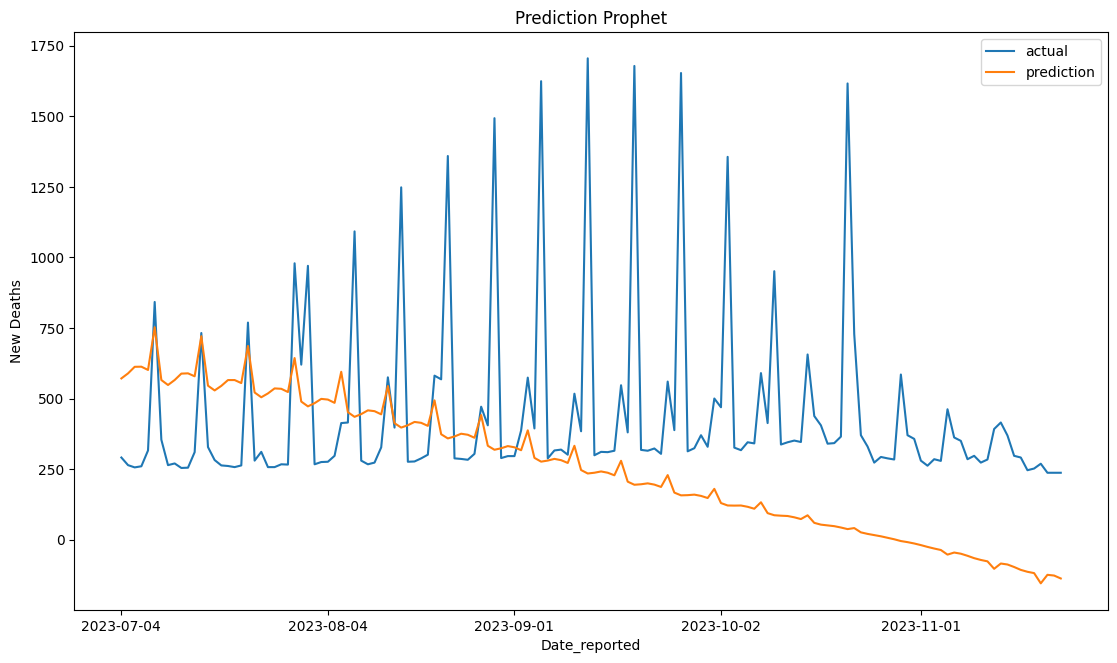

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [27]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2020-01-03,0,5.468060
1,2020-01-04,0,5.468060
2,2020-01-05,0,5.476464
3,2020-01-06,0,5.468060
4,2020-01-07,0,5.468060


In [28]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

17:03:21 - cmdstanpy - INFO - Chain [1] start processing
17:03:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  2.431816  1.559428  1.401286  0.187535  0.188956  0.16783  0.234286


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing
17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.681392  1.637496  1.462433  0.194788  0.201043  0.173678   

   coverage  
0  0.228571  


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
Optimi

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  2.56392  1.601224  1.440694  0.192564  0.194401  0.171954  0.230476


17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:32 - cmdstanpy - INFO - Chain [1] done processi

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  2.938617  1.71424  1.507868  0.199501  0.207832  0.177235  0.225714


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:0

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  2.578836  1.605875  1.441369  0.19238  0.198768  0.171788  0.229524


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:03:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:38 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
17:0

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.076724  1.754059  1.548632  0.204316  0.210729  0.181229   

   coverage  
0      0.22  


17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done proce

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  2.591586  1.60984  1.447757  0.193425  0.198754  0.172638  0.230476


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:4

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.028842  1.740357  1.534398  0.202466  0.210536  0.179724   

   coverage  
0  0.220952  


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] done pr

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  2.551236  1.597259  1.43252  0.191414  0.197792  0.170943  0.232381


17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Ne

  horizon      mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  2.99861  1.731649  1.53085  0.202548  0.207826  0.179809  0.212381


17:03:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] done processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] done processing
17:03:56 - cmdstanpy - INFO - Chain [1] done processing
17:03:56 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.326675  0.571555  0.426051  0.055523  0.043169  0.055116   

   coverage  
0   0.48381  


17:03:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.391213  0.625471  0.456312  0.059096  0.046105  0.058513   

   coverage  
0  0.437143  


17:04:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] done p

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.375525  0.612801  0.449533  0.057934  0.045275  0.057423   

   coverage  
0  0.471429  


17:04:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] done processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] done processing
17:04:02 - cmdstanpy - INFO - Chain [1] done processing
17:04:02 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.500552  0.707497  0.482916  0.061873  0.044416  0.061264   

   coverage  
0  0.442857  


17:04:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.376741  0.613792  0.45019  0.057906  0.045082  0.057382  0.467619


17:04:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] done processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.496407  0.704561  0.482384  0.061784  0.044542  0.06119      0.44


17:04:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start p

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.377621  0.614508  0.453849  0.058509  0.04586  0.057979      0.46


17:04:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] done p

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.508449  0.713056  0.490148  0.062644  0.045629  0.061976   

   coverage  
0  0.428571  


17:04:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:14 - cmdstanpy - INFO - Chain [1] done processing
17:04:14 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae    mape     mdape    smape  coverage
0 30 days  0.388046  0.622933  0.458775  0.0589  0.045358  0.05843  0.460952


17:04:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:16 - cmdstanpy - INFO - Chain [1] done processing
17:04:16 - cmdstanpy - INFO - Chain [1] done processing
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:16 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.508042  0.712771  0.493241  0.062932  0.046404  0.062379   

   coverage  
0  0.434286  


17:04:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:18 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.305351  0.552585  0.404305  0.052465  0.038961  0.052273   

   coverage  
0  0.479048  


17:04:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing
17:04:21 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.350817  0.592298  0.429069  0.055687  0.043137  0.055231   

   coverage  
0  0.450476  


17:04:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done p

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.36046  0.600383  0.435647  0.055914  0.042007  0.055811  0.448571


17:04:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.477344  0.690901  0.465707  0.059652  0.042786  0.059214   

   coverage  
0  0.445714  


17:04:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing
17:04:28 - cmdstanpy - INFO - Chain [1] start

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.349966  0.59158  0.426669  0.054926  0.040683  0.054819  0.472381


17:04:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] do

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.484095  0.695769  0.469847  0.06025  0.043922  0.059762  0.444762


17:04:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] start

  horizon      mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.35026  0.591827  0.429606  0.055232  0.041192  0.05513  0.465714


17:04:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.477298  0.690867  0.466504  0.059806  0.042941  0.059334   

   coverage  
0  0.447619  


17:04:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.350049  0.59165  0.427324  0.054982  0.040803  0.054869      0.46


17:04:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] done processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] done processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] done processing
17:04:41 - cmdstanpy - INFO - Chain [1] start

  horizon       mse     rmse       mae     mape     mdape     smape  coverage
0 30 days  0.483094  0.69505  0.468572  0.06001  0.043271  0.059569  0.441905


17:04:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] done processing
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.243435  0.493391  0.340185  0.04463  0.026553  0.044577  0.599048


17:04:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.245576  0.495557  0.353937  0.046632  0.031954  0.046515   

   coverage  
0  0.567619  


17:04:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] done processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] done processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] done processing
17:04:50 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse      mae      mape   mdape     smape  coverage
0 30 days  0.404381  0.635909  0.40917  0.052602  0.0315  0.052443  0.531429


17:04:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:54 - cmdstanpy - INFO - Chain [1] start processing
17:04:54 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.667835  0.817211  0.538885  0.067006  0.043915  0.066394   

   coverage  
0  0.424762  


17:04:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] done processing
17:04:57 - cmdstanpy - INFO - Chain [1] done processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] done processing
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.396506  0.629688  0.406614  0.052282  0.031127  0.052147   

   coverage  
0  0.525714  


17:05:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing
17:05:00 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.667648  0.817098  0.53647  0.066699  0.044482  0.066063  0.429524


17:05:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
17:05:04 - cmdstanpy - INFO - Chain [1] done processing
17:05:04 - cmdstanpy - INFO - Chain [1] done processing
17:05:04 - cmdstanpy - INFO - Chain [1] done

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.402247  0.63423  0.408766  0.052629  0.031632  0.052517   0.53619


17:05:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.686835  0.828755  0.535292  0.066532  0.044392  0.065895   

   coverage  
0  0.428571  


17:05:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.396385  0.629591  0.405007  0.052101  0.031209  0.051983   

   coverage  
0  0.535238  


17:05:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] st

  horizon     mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.6687  0.817741  0.539152  0.066971  0.043832  0.066572  0.430476
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


17:05:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] st

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.243435,0.493391,0.340185,0.04463,0.026553,0.044577,0.599048


In [29]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [30]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 110446.30
RMSE: 332.33
MAE: 171.61
MAPE: 30.69
SMAPE: 31.32


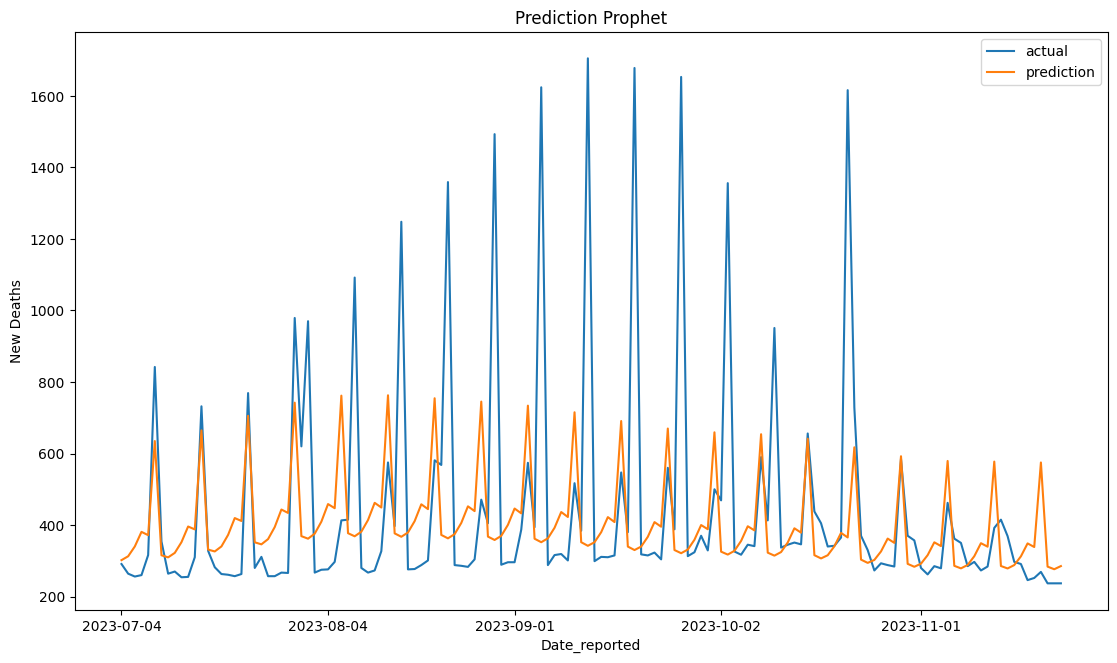

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()